# 🩺 Stroke Prediction: End-to-End Machine Learning Pipeline

# 1. Import Libraries
Import all necessary libraries for data processing, modeling, and visualization

In [266]:
import sys
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score,cross_val_predict
from sklearn.preprocessing import LabelEncoder,StandardScaler,RobustScaler
from sklearn.metrics import f1_score, classification_report,ConfusionMatrixDisplay, confusion_matrix,roc_auc_score,roc_curve, auc
from imblearn.over_sampling import SMOTE
import lightgbm as lgb
import xgboost as xgb
from sklearn.ensemble import StackingClassifier,RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
import matplotlib.pyplot as plt
import shap
import joblib
import seaborn as sns
from ydata_profiling import ProfileReport
%matplotlib inline

In [267]:
# Configuration file for paths and constants
sys.path.append(os.path.abspath(".."))
from config import DATA_RAW_PATH, DATA_PREDICTED_PATH,DATA_PROCESSED_PATH, MODEL_DIR, TRAIN_FILE, TEST_FILE,TRAIN_PREPROCESSED_FILE,TEST_PREPROCESSED_FILE, SAMPLE_SUBMISSION_FILE, RANDOM_STATE,SCALING_FILE_NAME

In [268]:
import warnings
warnings.filterwarnings('ignore')

## 2. Dataset Meta Information

**Files:**
- `train.csv`: Data containing all available features and the stroke response.
- `test.csv`: Unseen stroke patients with all available predictors but missing stroke. Used for model prediction.
- `sample_submission.csv`: A sample submission file in the correct format.

**Data Dictionary:**
| Column            | Type     | Description                                                                                 | Values/Range                        |
|-------------------|----------|---------------------------------------------------------------------------------------------|-------------------------------------|
| `id`              | Integer  | Unique identifier for each record                                                            | Any integer                         |
| `gender`          | String   | Gender of the patient                                                                       | `Male`, `Female`                    |
| `age`             | Float    | Age of the patient in years                                                                 | Any positive float                  |
| `hypertension`    | Integer  | Indicates whether the patient has hypertension                                              | `0`: No, `1`: Yes                   |
| `heart_disease`   | Integer  | Indicates whether the patient has heart disease                                             | `0`: No, `1`: Yes                   |
| `ever_married`    | String   | Marital status of the patient                                                               | `Yes`, `No`                         |
| `work_type`       | String   | Type of employment                                                                          | `Private`, `Self-employed`, `Govt_job`, `Children`, etc. |
| `Residence_type`  | String   | Type of residence                                                                          | `Urban`, `Rural`                    |
| `avg_glucose_level`| Float   | Average glucose level of the patient (mg/dL)                                                | Any positive float                  |
| `bmi`             | Float    | Body Mass Index (BMI) of the patient                                                        | Any positive float                  |
| `smoking_status`  | String   | Smoking status                                                                             | `never smoked`, `formerly smoked`, `smokes`, `Unknown` |
| `stroke`          | Integer  | Target variable indicating whether the patient had a stroke (**[TARGET]**)                  | `0`: No, `1`: Yes                   |

# 3. Load Data
 Load training and test datasets

In [269]:
def read_data(base_path, file_name):
    """Reads a CSV file from the specified base path and returns a DataFrame."""
    try:
        df = pd.read_csv(f'{base_path}/{file_name}')
        return df
    except Exception as e:
        print(f"Error reading {file_name}: {e}")
        return pd.DataFrame()

In [270]:
def save_data(df, base_path, file_name):
    """Writes a DataFrame to a CSV file in the specified base path."""
    try:
        df.to_csv(f'{base_path}/{file_name}', index=False)
        print(f"Data written to {file_name} successfully.")
    except Exception as e:
        print(f"Error writing {file_name}: {e}")

In [271]:
# Load the training data
train = read_data(DATA_RAW_PATH, TRAIN_FILE)
# Load the test data
test = read_data(DATA_RAW_PATH, TEST_FILE)
# Load the sample submission file
sample_solution = read_data(DATA_RAW_PATH, SAMPLE_SUBMISSION_FILE)

# Create copies of the original train and test data
# This is useful for keeping the original data intact for future reference or comparisons
orgnigal_train=train.copy(deep=True)
orgnigal_test=test.copy(deep=True)

# 4. Exploratory Data Analysis (EDA)

**4.1 Check dataset shape**

In [272]:
print("Train Data Shape:", train.shape)
print("Test Data Shape:", test.shape)

Train Data Shape: (12243, 12)
Test Data Shape: (3061, 11)


**4.2   Check dataset meta info**  

    Display data types and missing values

In [273]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12243 entries, 0 to 12242
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 12243 non-null  int64  
 1   gender             12243 non-null  object 
 2   age                12243 non-null  float64
 3   hypertension       12243 non-null  int64  
 4   heart_disease      12243 non-null  int64  
 5   ever_married       12243 non-null  object 
 6   work_type          12243 non-null  object 
 7   Residence_type     12243 non-null  object 
 8   avg_glucose_level  12243 non-null  float64
 9   bmi                12243 non-null  float64
 10  smoking_status     12243 non-null  object 
 11  stroke             12243 non-null  int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 1.1+ MB


**4.3 Statistical Summary**  

Show summary statistics for numerical features

In [274]:
train.describe(percentiles=[0.05,0.25, 0.5, 0.75,0,0.99])

id           age  hypertension  heart_disease  \
count  12243.000000  12243.000000  12243.000000   12243.000000   
mean    6122.000000     41.344951      0.049416       0.023279   
std     3534.394007     21.518463      0.216744       0.150793   
min        1.000000      0.080000      0.000000       0.000000   
0%         1.000000      0.080000      0.000000       0.000000   
5%       613.100000      4.000000      0.000000       0.000000   
25%     3061.500000     25.000000      0.000000       0.000000   
50%     6122.000000     43.000000      0.000000       0.000000   
75%     9182.500000     57.000000      0.000000       0.000000   
99%    12120.580000     81.000000      1.000000       1.000000   
max    12243.000000     82.000000      1.000000       1.000000   

       avg_glucose_level           bmi       stroke  
count       12243.000000  12243.000000  12243.00000  
mean           88.820804     28.074400      0.04133  
std            24.957986      6.707892      0.19906  
min            55.220000     10.300000      0.00000  
0%             55.220000     10.300000      0.00000  
5%             60.980000     17.900000      0.00000  
25%            74.880000     23.500000      0.00000  
50%            85.030000     27.600000      0.00000  
75%            96.840000     31.900000      0.00000  
99%           215.848800     46.900000      1.00000  
max           267.600000     80.100000      1.00000

**4.4 View Sample Data**  
Display the first few rows of the training data

In [275]:
train.head()

id  gender   age  hypertension  heart_disease ever_married work_type  \
0   1    Male  50.0             0              0          Yes   Private   
1   2  Female  52.0             0              0          Yes   Private   
2   3  Female  26.0             0              0           No  Govt_job   
3   4  Female  37.0             0              0          Yes   Private   
4   5    Male  59.0             0              0          Yes   Private   

  Residence_type  avg_glucose_level   bmi   smoking_status  stroke  
0          Rural              88.10  29.1  formerly smoked       0  
1          Rural              80.07  38.9           smokes       0  
2          Urban              89.11  23.3           smokes       0  
3          Rural              81.36  36.1     never smoked       0  
4          Rural              82.59  29.6     never smoked       1

**4.5 Check missing values**

In [276]:
print("Missing values in train data:")
print(train.isnull().sum())
print("\n")
print("Missing values in test data:")
print(test.isnull().sum())

Missing values in train data:
id                   0
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64


Missing values in test data:
id                   0
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
dtype: int64


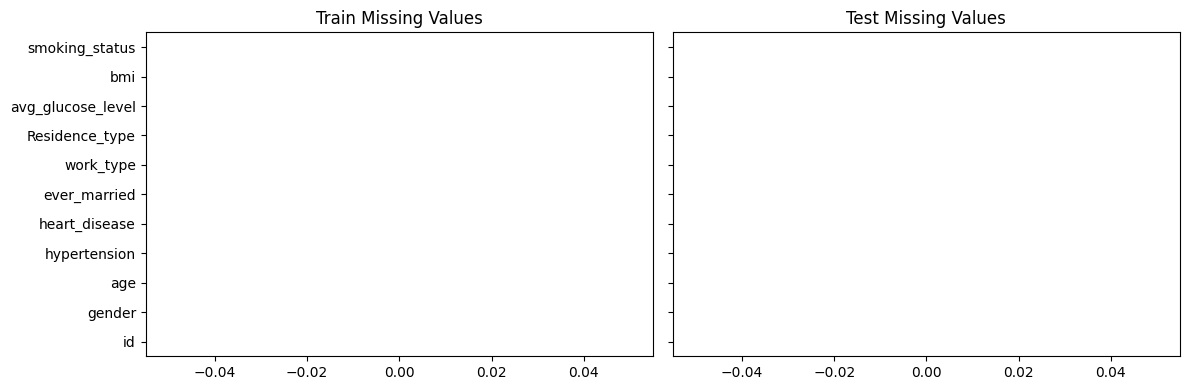

In [277]:
# Visualize missing values in train data
fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
train.isna().sum().plot.barh(ax=axes[0], color='skyblue')
test.isna().sum().plot.barh(ax=axes[1], color='salmon')
axes[0].set_title('Train Missing Values')
axes[1].set_title('Test Missing Values')
plt.tight_layout()
plt.show()

* observation: no missing value for train and test dataset

**4.6 Data Profiling**  
 Generate an automated profiling report for EDA

In [278]:
profile = ProfileReport(train, title="Stroke Prediction Dataset Report", explorative=True)
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 12/12 [00:00<00:00, 215.88it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

**4.7 Categorizing features based on data types**

In [279]:
# Categorical and numerical columns
# These lists categorize the features based on their data types
cat_cols = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
cat_binary_cols = ['hypertension', 'heart_disease']
num_cols= ['age', 'avg_glucose_level', 'bmi']

**4.8 Target Variable Distribution check and visualize**  
 

In [280]:
# Check for unique values in categorical columns
print("Stroke Value Counts:")
print(train['stroke'].value_counts())
print("\nStroke Percentage Distribution:")
print(train['stroke'].value_counts(normalize=True) * 100)

Stroke Value Counts:
stroke
0    11737
1      506
Name: count, dtype: int64

Stroke Percentage Distribution:
stroke
0    95.867026
1     4.132974
Name: proportion, dtype: float64


**4.9 Visualize imbalance in the target variable**  

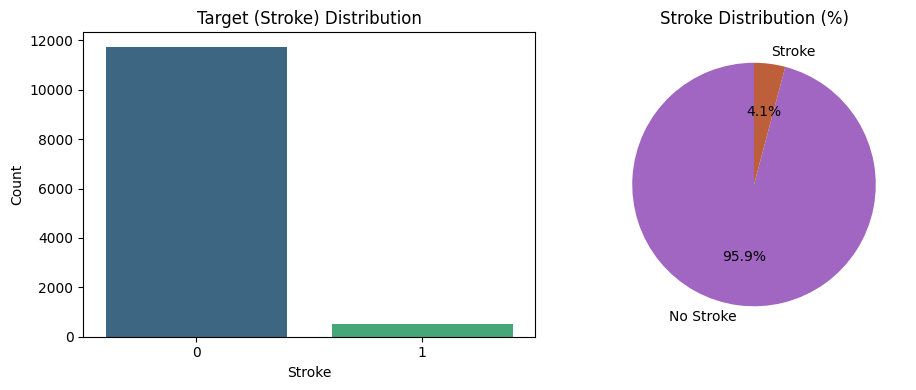

In [281]:
# Visualize the distribution of the target variable (stroke)
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=False)
sns.countplot(x='stroke', data=train, ax=axes[0], palette='viridis')
axes[0].set_title('Target (Stroke) Distribution')
axes[0].set_xlabel('Stroke')
axes[0].set_ylabel('Count')

axes[1].pie(
    train['stroke'].value_counts(normalize=True),
    labels=['No Stroke', 'Stroke'],
    autopct='%1.1f%%',
    startangle=90,
    colors=["#a066c2", "#bc5f3a"]
)
axes[1].set_title('Stroke Distribution (%)')
plt.tight_layout()
plt.show()


* Observation: The target(stroke) is highly imbalance for training

**4.10 Check the scewness of numerical features**

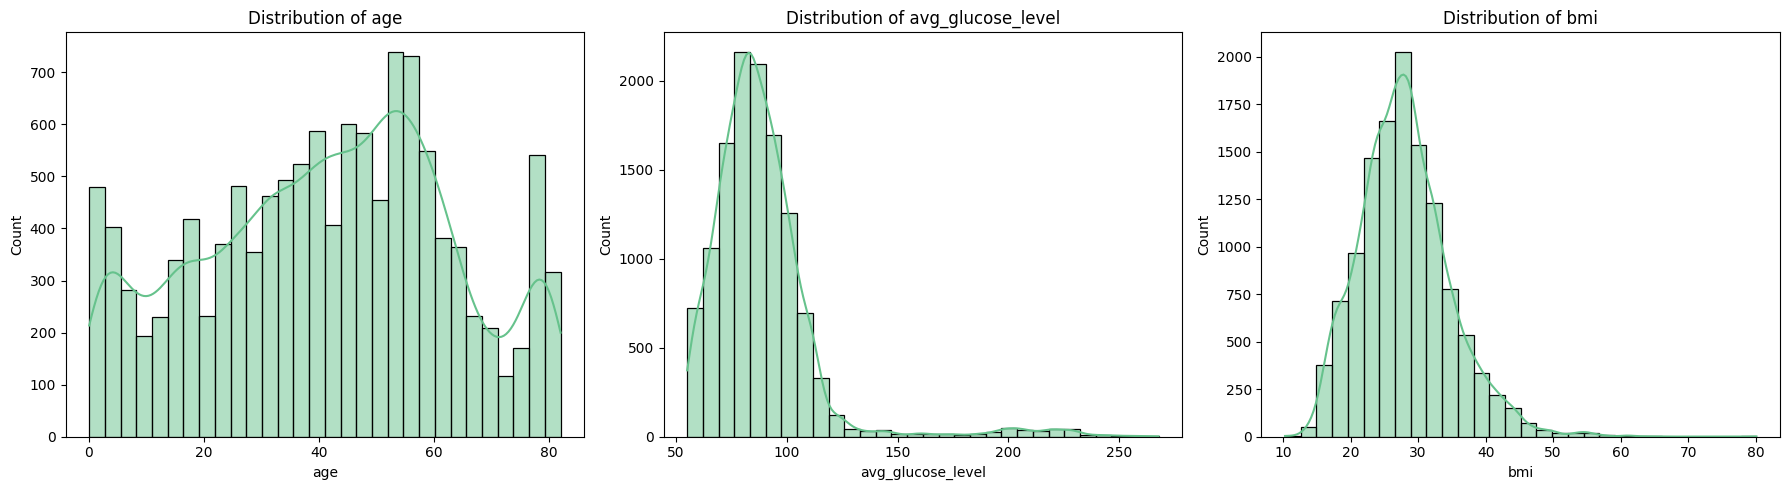

In [282]:
# Check the scewness of numerical features
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for i, col in enumerate(num_cols):
    sns.histplot(data=train, x=col, kde=True, bins=30, ax=axes[i], color="#66c28c")
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Count')
plt.tight_layout()
plt.show()

* **Observation** : The BMI and avg_clucose_level are rightly screwed

**4.11 Check the outliers in the numerical features**

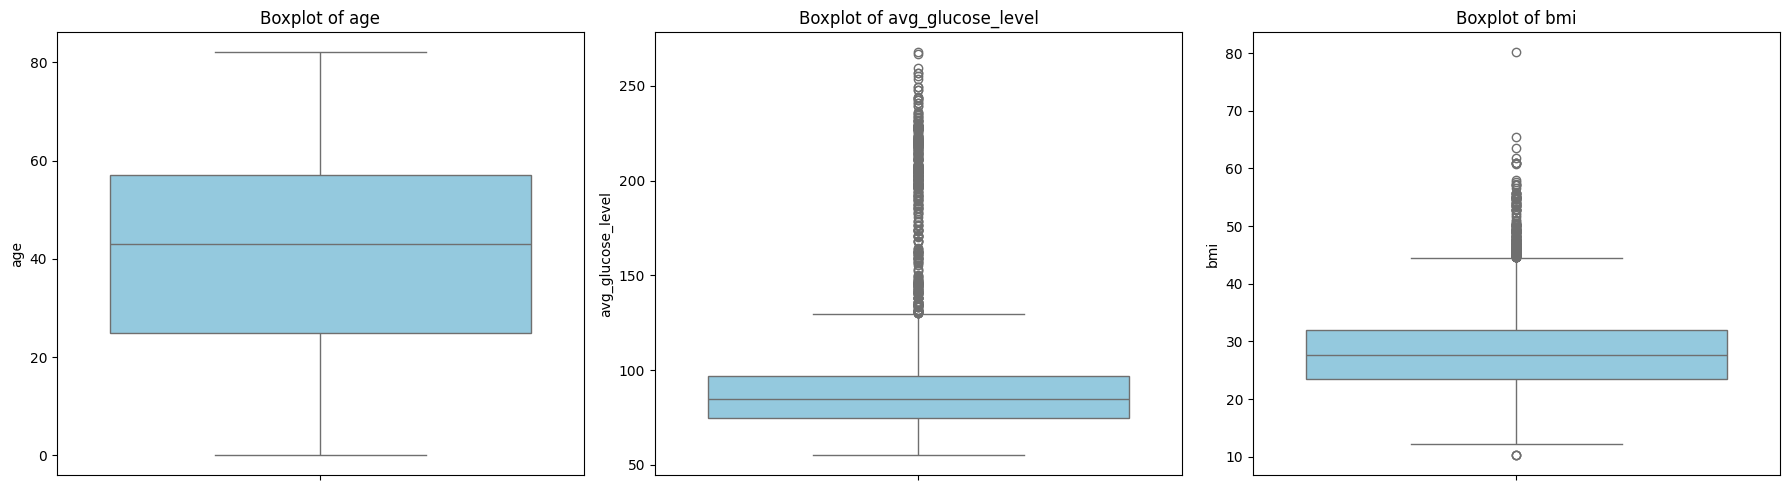

In [283]:
# Check the outliers in numerical features
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for i, col in enumerate(num_cols):
    sns.boxplot(data=train, y=col, ax=axes[i], color='skyblue')
    axes[i].set_title(f'Boxplot of {col}')
    axes[i].set_xlabel('')
    axes[i].set_ylabel(col)
plt.tight_layout()
plt.show()

In [284]:
# Check the outliers in numerical features
for col in num_cols:
    Q1 = train[col].quantile(0.25)
    Q3 = train[col].quantile(0.75)
    # Finding IQR
    IQR = (Q3 - Q1)
    da=(train[col] < (Q1 - 1.5 * IQR)) | (train[col] > (Q3 + 1.5 * IQR))
    print(f"\nOutliers in {col}:\n")
    print(da.value_counts())
    print(f"Percentage of outliers in {col}: {da.mean() * 100:.2f}%")
    print(f"Percentage of outliers with stroke: {len(train[da & train['stroke']==1]) / len(train) * 100:.2f}%")

    # Finding extreme outliers
    # Extreme outliers are defined as values below the 1st percentile or above the 99th percentile
    lower = train[col].quantile(0.01)
    upper = train[col].quantile(0.99)
    extream_outlier = train[(train[col] <= lower) & (train[col] >= upper)]
    print(f"Percentage of extreme outliers in {col}: {len(extream_outlier)} ({len(extream_outlier) / len(train) * 100:.3f})%\n")


Outliers in age:

age
False    12243
Name: count, dtype: int64
Percentage of outliers in age: 0.00%
Percentage of outliers with stroke: 0.00%
Percentage of extreme outliers in age: 0 (0.000)%


Outliers in avg_glucose_level:

avg_glucose_level
False    11824
True       419
Name: count, dtype: int64
Percentage of outliers in avg_glucose_level: 3.42%
Percentage of outliers with stroke: 0.69%
Percentage of extreme outliers in avg_glucose_level: 0 (0.000)%


Outliers in bmi:

bmi
False    12033
True       210
Name: count, dtype: int64
Percentage of outliers in bmi: 1.72%
Percentage of outliers with stroke: 0.08%
Percentage of extreme outliers in bmi: 0 (0.000)%



* **Observation:** 
* BMI has 210(1.71%) outliers 
* avg_glucose_level has 419(3.42%) outliers
* Percentage of outliers of bmi with stroke is 0.08% and avg_glucose_level is 3.42%
* Since it has outliers standard scaler may stretch the scale, leading to shrunken "normal" values. Impact model performance, especially for algorithms like SVM, KNN, and Logistic Regression
* RobustScaler uses the median and IQR (interquartile range) — it is resistant to outliers
* No extream outliers observed
 

**4.12 Categorical Features: Count Plots**

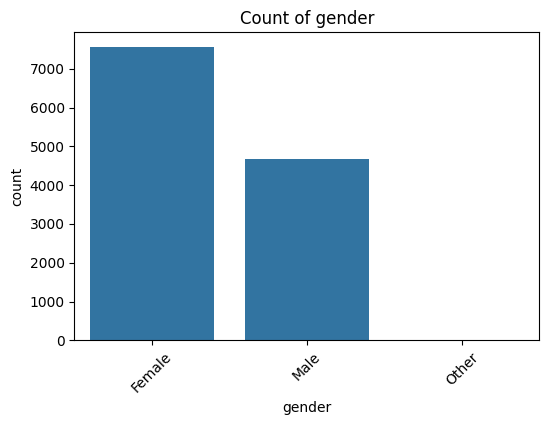

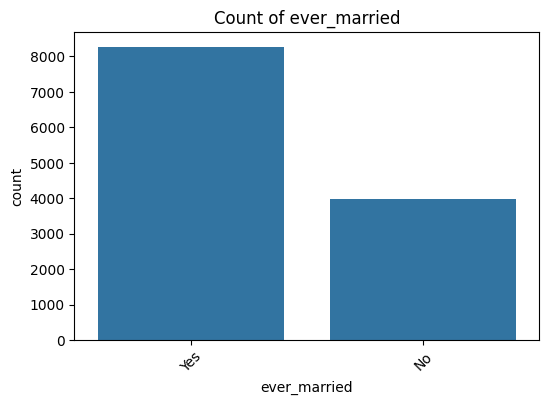

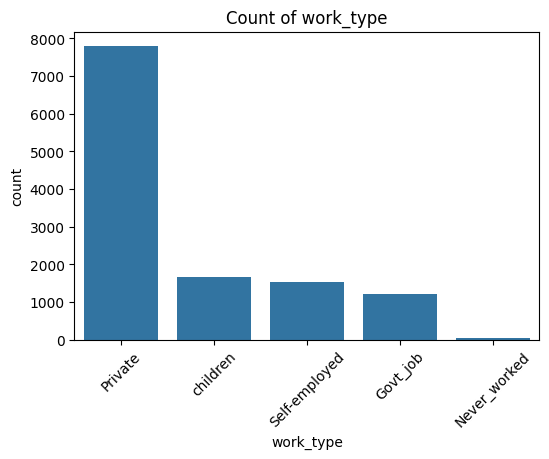

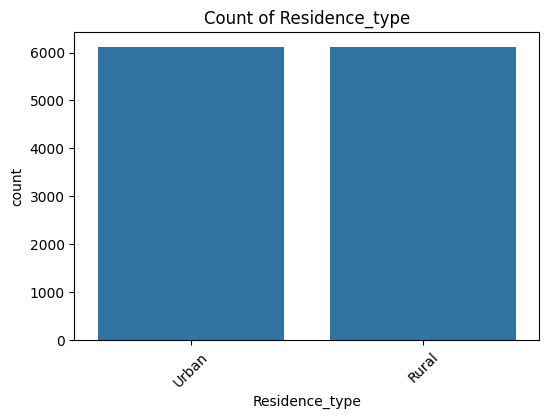

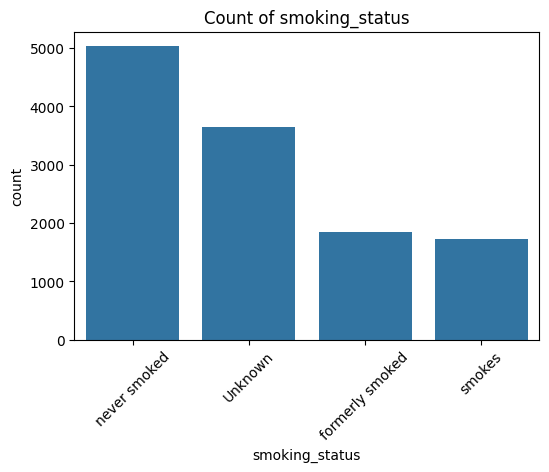

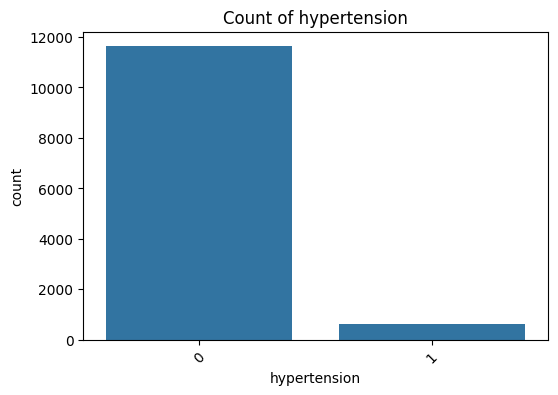

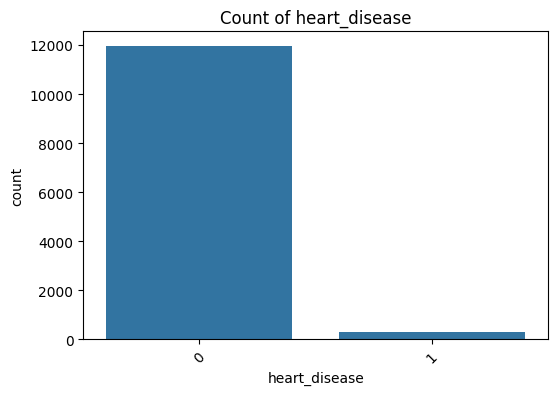

In [285]:
# Categorical Features: Count Plots
# Visualize the count of each category in categorical columns
for col in cat_cols + cat_binary_cols:
    plt.figure(figsize=(6, 4))
    sns.countplot(data=train, x=col, order=train[col].value_counts().index)
    plt.title(f'Count of {col}')
    plt.xticks(rotation=45)
    plt.show()

**4.13 Relationship with Target (Stroke)**  


4.13.1 Numerical features vs stroke

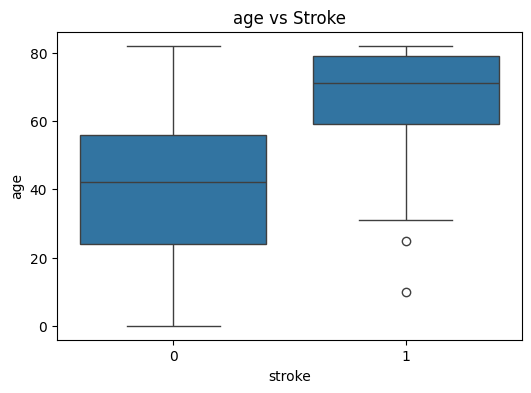

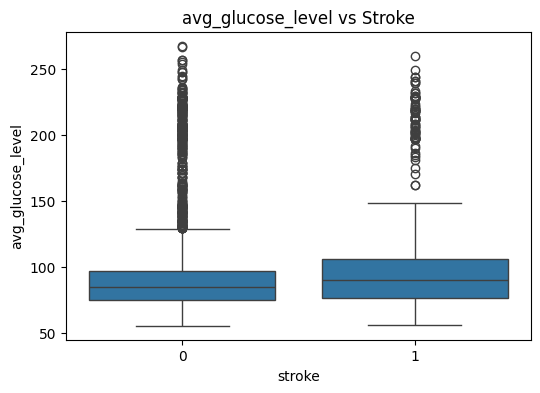

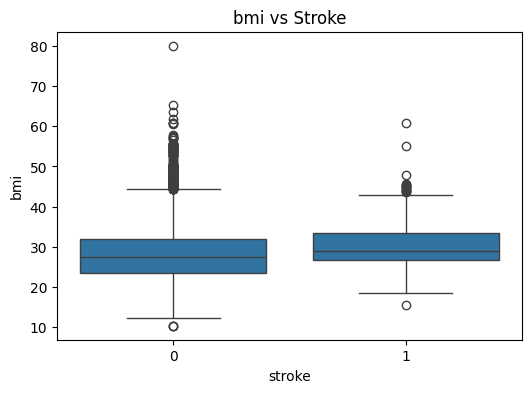

In [286]:
# Numerical features vs stroke
for col in num_cols:
    plt.figure(figsize=(6, 4))
    sns.boxplot(data=train, x='stroke', y=col)
    plt.title(f'{col} vs Stroke')
    plt.show()

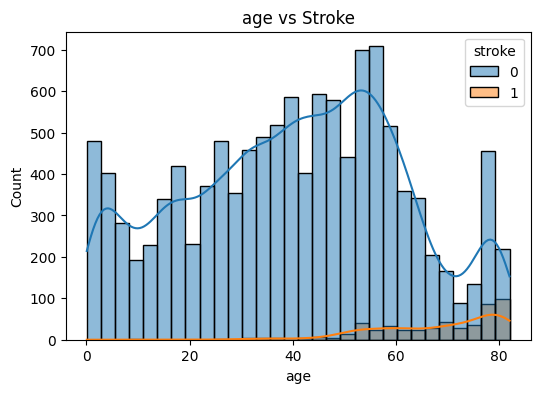

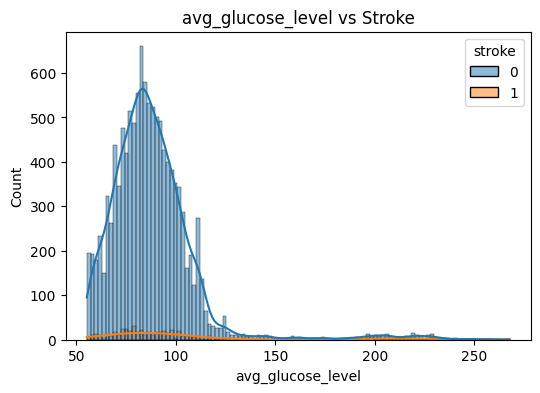

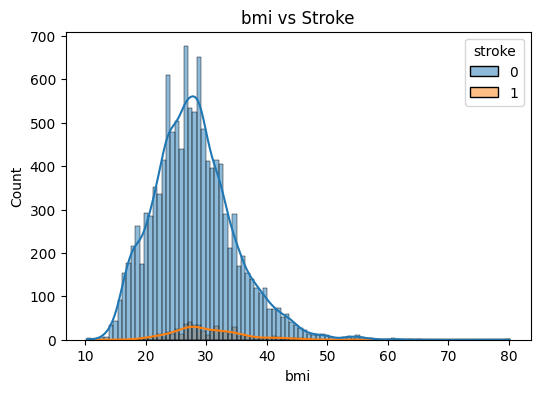

In [287]:
# Visualize the distribution of numerical features with respect to the target variable (stroke)
# This helps to understand how each numerical feature is distributed across the two classes of the target variable
for col in num_cols:
    plt.figure(figsize=(6, 4))
    sns.histplot(data=train,x=col, hue='stroke', kde=True)
    plt.title(f'{col} vs Stroke')
    plt.show()

* **Observation:** With the high values strike chances are more

4.13.2 Categorical Features: Count Plots

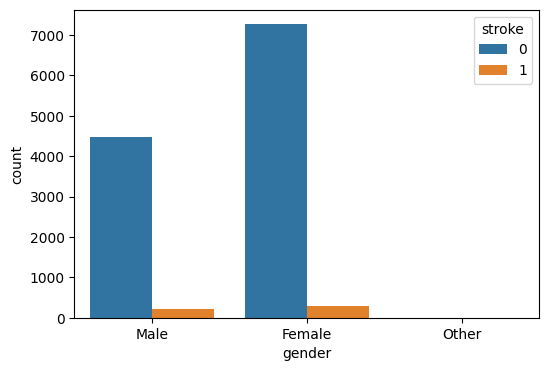

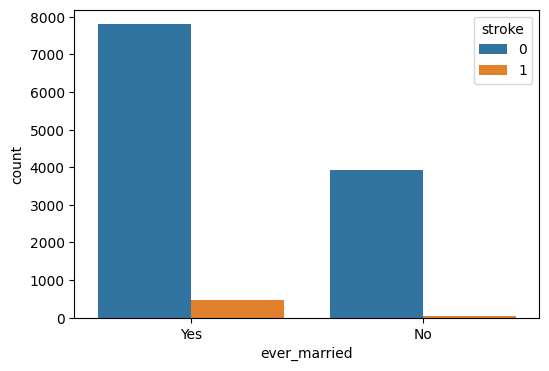

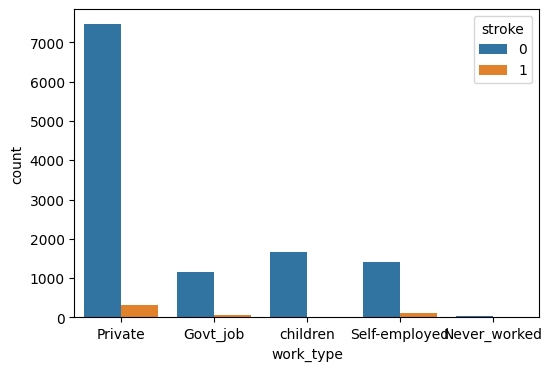

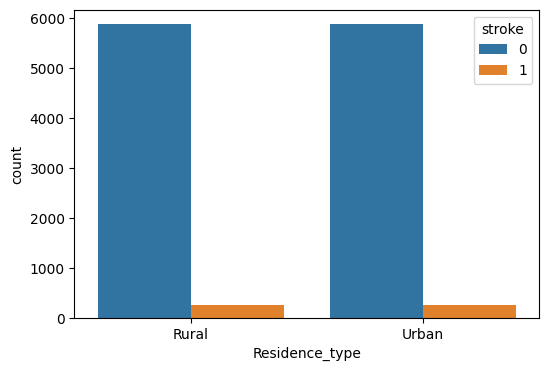

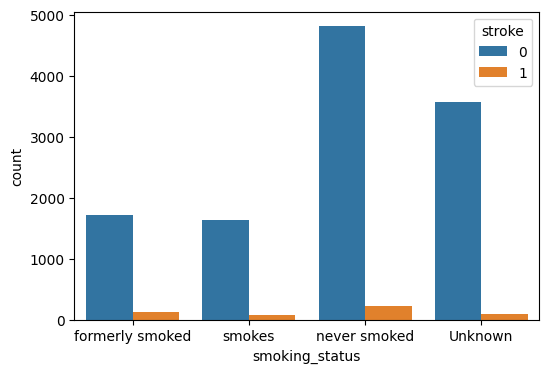

In [288]:
# Categorical Features: Count Plots
# Visualize the count of each category in categorical columns
for col in cat_cols:
    plt.figure(figsize=(6, 4))
    sns.countplot(data=train, x=col, hue='stroke')
    plt.show()

* **Obervations:**  
* Private sector job holders are having high chance of stroke
* Female are having high chance of stroke

4.13.3 Coorelation check between the features

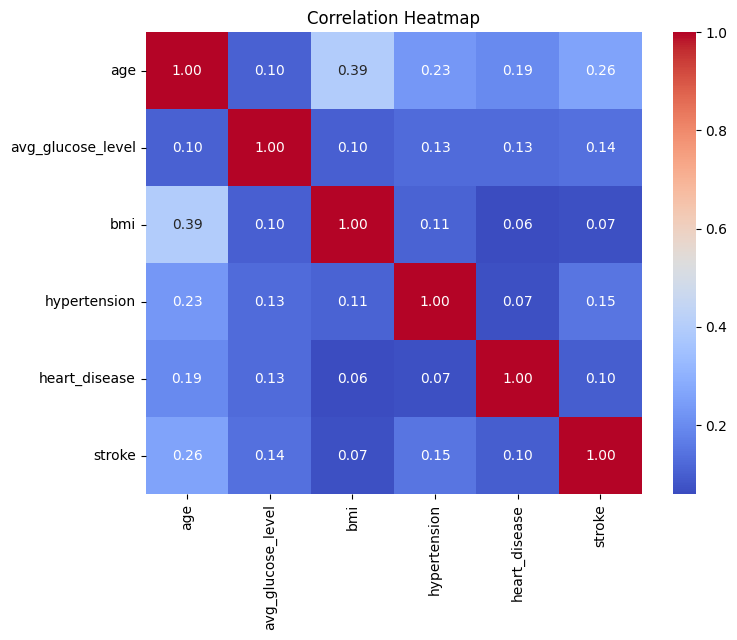

In [289]:
# Coorelation check between the features
corr_features = ['age', 'avg_glucose_level', 'bmi', 'hypertension', 'heart_disease', 'stroke']
corr_matrix = train[corr_features].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

* **Observations:**
* There is weak correlation between the features and the target variable
* 'avg_glucose_level' and 'bmi' have a moderate correlation with 'stroke
* High correlation between 'age' and 'stroke' 0.39
* Rest features are having coorelation < 0.39
* No conclusive statistical insights for the hitmap

* Based on the pandas profiling obervation coverting numeric-binary value attributes to string

# 6. Data Preprocessing
 

In [290]:
# Combine train and test data for preprocessing
train['is_train'] = 1
test['is_train'] = 0
test['stroke'] = np.nan
full_data = pd.concat([train, test], ignore_index=True)

In [291]:
# Display the first few rows of the combined data
full_data.head()

id  gender   age  hypertension  heart_disease ever_married work_type  \
0   1    Male  50.0             0              0          Yes   Private   
1   2  Female  52.0             0              0          Yes   Private   
2   3  Female  26.0             0              0           No  Govt_job   
3   4  Female  37.0             0              0          Yes   Private   
4   5    Male  59.0             0              0          Yes   Private   

  Residence_type  avg_glucose_level   bmi   smoking_status  stroke  is_train  
0          Rural              88.10  29.1  formerly smoked     0.0         1  
1          Rural              80.07  38.9           smokes     0.0         1  
2          Urban              89.11  23.3           smokes     0.0         1  
3          Rural              81.36  36.1     never smoked     0.0         1  
4          Rural              82.59  29.6     never smoked     1.0         1

**Check distinct values in categorical variables**

In [292]:
# Check unique values in categorical columns
# cat_cols = ['ever_married', 'Residence_type','gender', 'work_type', 'smoking_status','hypertension', 'heart_disease']
for c in cat_cols:
    print(f"{c}: {full_data[c].unique()}" )

gender: ['Male' 'Female' 'Other']
ever_married: ['Yes' 'No']
work_type: ['Private' 'Govt_job' 'children' 'Self-employed' 'Never_worked']
Residence_type: ['Rural' 'Urban']
smoking_status: ['formerly smoked' 'smokes' 'never smoked' 'Unknown']


In [293]:
# Check count of unique values in gender column
full_data["gender"].value_counts()

gender
Female    9446
Male      5857
Other        1
Name: count, dtype: int64

In [294]:
# Fill missing values in 'bmi' with the median and 'smoking_status' with 'Unknown'
full_data['bmi'] = full_data['bmi'].fillna(full_data['bmi'].median())
full_data['smoking_status'] = full_data['smoking_status'].fillna('Unknown')

In [295]:
full_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15304 entries, 0 to 15303
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 15304 non-null  int64  
 1   gender             15304 non-null  object 
 2   age                15304 non-null  float64
 3   hypertension       15304 non-null  int64  
 4   heart_disease      15304 non-null  int64  
 5   ever_married       15304 non-null  object 
 6   work_type          15304 non-null  object 
 7   Residence_type     15304 non-null  object 
 8   avg_glucose_level  15304 non-null  float64
 9   bmi                15304 non-null  float64
 10  smoking_status     15304 non-null  object 
 11  stroke             12243 non-null  float64
 12  is_train           15304 non-null  int64  
dtypes: float64(4), int64(4), object(5)
memory usage: 1.5+ MB


# 7. Feature Engineering
**Encode categorical variables using One HOT Encodering**

In [296]:
# Map binary categorical variables to numerical values
binary_map = {'Yes': 1, 'No': 0, 'Urban': 1, 'Rural': 0}
full_data['ever_married'] = full_data['ever_married'].map(binary_map)
full_data['Residence_type'] = full_data['Residence_type'].map(binary_map)

one_hot_encode_features=['gender', 'work_type', 'smoking_status']
# One-hot encode categorical variables
full_data = pd.get_dummies(full_data, columns=one_hot_encode_features, drop_first=True)

In [297]:
# Display the first few rows of the processed data
full_data.head()

id   age  hypertension  heart_disease  ever_married  Residence_type  \
0   1  50.0             0              0             1               0   
1   2  52.0             0              0             1               0   
2   3  26.0             0              0             0               1   
3   4  37.0             0              0             1               0   
4   5  59.0             0              0             1               0   

   avg_glucose_level   bmi  stroke  is_train  gender_Male  gender_Other  \
0              88.10  29.1     0.0         1         True         False   
1              80.07  38.9     0.0         1        False         False   
2              89.11  23.3     0.0         1        False         False   
3              81.36  36.1     0.0         1        False         False   
4              82.59  29.6     1.0         1         True         False   

   work_type_Never_worked  work_type_Private  work_type_Self-employed  \
0                   False               True                    False   
1                   False               True                    False   
2                   False              False                    False   
3                   False               True                    False   
4                   False               True                    False   

   work_type_children  smoking_status_formerly smoked  \
0               False                            True   
1               False                           False   
2               False                           False   
3               False                           False   
4               False                           False   

   smoking_status_never smoked  smoking_status_smokes  
0                        False                  False  
1                        False                   True  
2                        False                   True  
3                         True                  False  
4                         True                  False

In [298]:
# Split the combined data back into train and test sets.len. 'is_train' column indicates whether the row is from the training set (1) or
train = full_data[full_data['is_train'] == 1].drop(['is_train'], axis=1)
test = full_data[full_data['is_train'] == 0].drop(['is_train', 'stroke'], axis=1)

**Save the preprocessed data for future reference**

In [299]:
save_data(train, DATA_PROCESSED_PATH, TRAIN_PREPROCESSED_FILE)
save_data(test, DATA_PROCESSED_PATH, TEST_PREPROCESSED_FILE)

Data written to train_preprocessed.csv successfully.
Data written to test_preprocessed.csv successfully.


# 8. Feature Selection
**Select features for modeling (exclude 'id' and 'stroke')**

In [300]:
features = [col for col in train.columns if col not in ['id', 'stroke']]
X = train[features]
y = train['stroke'].astype(int)

In [301]:
X.head()

age  hypertension  heart_disease  ever_married  Residence_type  \
0  50.0             0              0             1               0   
1  52.0             0              0             1               0   
2  26.0             0              0             0               1   
3  37.0             0              0             1               0   
4  59.0             0              0             1               0   

   avg_glucose_level   bmi  gender_Male  gender_Other  work_type_Never_worked  \
0              88.10  29.1         True         False                   False   
1              80.07  38.9        False         False                   False   
2              89.11  23.3        False         False                   False   
3              81.36  36.1        False         False                   False   
4              82.59  29.6         True         False                   False   

   work_type_Private  work_type_Self-employed  work_type_children  \
0               True                    False               False   
1               True                    False               False   
2              False                    False               False   
3               True                    False               False   
4               True                    False               False   

   smoking_status_formerly smoked  smoking_status_never smoked  \
0                            True                        False   
1                           False                        False   
2                           False                        False   
3                           False                         True   
4                           False                         True   

   smoking_status_smokes  
0                  False  
1                   True  
2                   True  
3                  False  
4                  False

In [302]:
y.head()

0    0
1    0
2    0
3    0
4    1
Name: stroke, dtype: int64

# 9. Handle Class Imbalance
**Apply SMOTE to balance the target classes**

In [303]:
smote = SMOTE(random_state=RANDOM_STATE, sampling_strategy='minority')
X_resampled, y_resampled = smote.fit_resample(X, y)

# 9.1. Visualize Resampled Distribution
**Plot the distribution after SMOTE resampling**

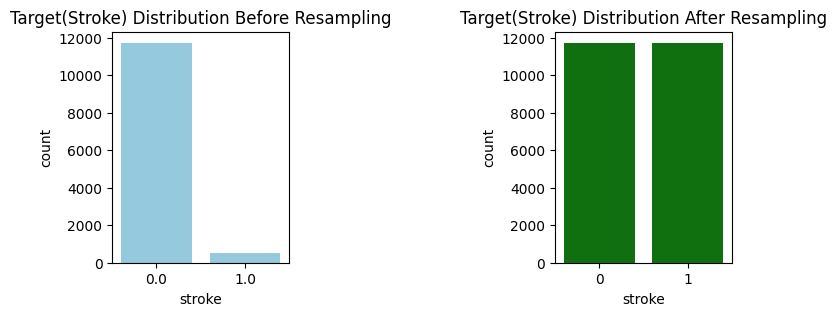

In [304]:
plt.figure(figsize=(8, 3))
plt.subplot(1, 2, 1)
sns.countplot(x='stroke', data=train,color='skyblue')
plt.title("Target(Stroke) Distribution Before Resampling")


plt.subplot(1, 2, 2)
sns.countplot(x=y_resampled,color='green')
plt.title("Target(Stroke) Distribution After Resampling")
plt.subplots_adjust(wspace=1.5)
plt.show()

# 10. Model Training Functions
**Define reusable functions for model training and evaluation**

**10.1 Feature scaling function**

In [305]:
def scale_features(scaler,X_train, X_val, X_test,features=['bmi', 'avg_glucose_level']):
    """
    Scales features using defined scaler. Returns scaled train, val, and optionally test sets.
    """
    # scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train[features])
    X_val_scaled = scaler.transform(X_val[features])
    # if X_test is not None:
    X_test_scaled = scaler.transform(X_test[features])
        #return X_train_scaled, X_val_scaled, X_test_scaled
    save_pickle_file(scaler, SCALING_FILE_NAME,MODEL_DIR)
    # return X_train_scaled, X_val_scaled
    return X_train_scaled, X_val_scaled, X_test_scaled

**10.2 Model training function**

In [306]:
def train_model(model, X_train, y_train):
    model.fit(X_train, y_train)
    return model

**10.3 ROC AUC plot function**

In [307]:
def roc_auc_plot(y_true, y_scores):
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='blue', label='ROC curve (area = {:.2f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], color='red', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='lower right')
    plt.show()
    print("ROC AUC Score:", roc_auc)

**10.4 Model Evaluation function**

In [308]:
def evaluate_model(model, X_val, y_val,model_name):
    y_pred = model.predict(X_val)
    print(f"Model: {model_name}")
    f1 = f1_score(y_val, y_pred)
    print("F1 Score:", f1_score(y_val, y_pred))
    report = classification_report(y_val, y_pred)
    print("Classification Report:\n", classification_report(y_val, y_pred))
    cm = confusion_matrix(y_val, y_pred)
    # sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues')
    plt.title(f"Confusion Matrix - {model_name}")
    plt.show()
    roc_auc_plot(y_val, model.predict_proba(X_val)[:, 1])
    return model

**10.5 Tune model function**

In [309]:
def tune_model(model,X_train,y_train,X_val,y_val, param_grid, name,cv=5,scoring='f1',n_jobs=-1):
    print(f"\n\n--- Tuning {name} ---")
    grid = GridSearchCV(model, param_grid, cv=cv, scoring=scoring, verbose=1, n_jobs=n_jobs)
    grid.fit(X_train, y_train)
    best_model = grid.best_estimator_
    y_pred = best_model.predict(X_val)
    
    print(f"Best Params for {name}: {grid.best_params_}")
    print("F1 Score:", f1_score(y_val, y_pred))
    print("Classification Report:\n", classification_report(y_val, y_pred))
    sns.heatmap(confusion_matrix(y_val, y_pred), annot=True, fmt='d', cmap='Blues')
    plt.title(f"{name} Confusion Matrix")
    plt.show()
    roc_auc_plot(y_val, model.predict_proba(X_val)[:, 1])
    return best_model

**10.6 Define model and params tunning**

In [310]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=RANDOM_STATE),
    "SVM": SVC(probability=True, random_state=RANDOM_STATE),
    "Naive Bayes": GaussianNB(),
    "KNN": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(random_state=RANDOM_STATE),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE),
    "XGBoost": xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=RANDOM_STATE),
    "LightGBM": lgb.LGBMClassifier(random_state=RANDOM_STATE),
    
}

standard_scaler = StandardScaler()
robust_scaler = RobustScaler()

param_tuning = {
    "Logistic Regression": {
    'C': [0.1, 1, 10],
    'solver': ['lbfgs'],
    'max_iter': [1000]
    },
    "Random Forest": {
        'n_estimators': [100, 200],
        'max_depth': [5, 10, None],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2]
    },
    "XGBoost": {
        'n_estimators': [100, 200],
        'max_depth': [3, 5, 10],
        'learning_rate': [0.01, 0.1, 0.2],
        'subsample': [0.8, 1.0]
    },
    "LightGBM": {
        'n_estimators': [100, 200],
        'max_depth': [3, 5, -1],
        'learning_rate': [0.01, 0.1]
    },
    "Naive Bayes": {'var_smoothing': np.logspace(-12, -6, 7)},
    "SVM" : {'C': [0.1, 1], 'kernel': ['linear', 'rbf'], 'probability': [True]},
    "KNN": {'n_neighbors': [3, 5, 7], 'weights': ['uniform', 'distance']},
    "Decision Tree":{'max_depth': [3, 5, 10], 'min_samples_split': [2, 5]}
}

**10.7 Final data save function**

In [311]:
def save_final_predictions(model, test,features, model_name,predicated_data_path=DATA_PREDICTED_PATH):
    """
    Generate predictions on the test set and save the submission file.
    """
    predictions = model.predict(test[features])
    prob=model.predict_proba(test[features])[0][1]
    submission = pd.DataFrame({
        'id': test['id'],
        'stroke': predictions,
        'probability': prob
    })
    submission.to_csv(f'{predicated_data_path}/submission_{model_name}.csv', index=False)
    print(f"Submission file saved as 'submission_{model_name}.csv'")

**10.8 Save and read model function**

In [312]:
def save_pickle_file(model, model_name,model_dir=MODEL_DIR):
    try:
        os.makedirs(model_dir, exist_ok=True)
        joblib.dump(model, f'{model_dir}/{model_name}.pkl')
        print(f"Pickle File saved as {model_name}.pkl")
    except Exception as e:
        print(f"Error saving model {model_name}: {e}")
    
def load_pickle_file(model_name,model_dir=MODEL_DIR):
    try:
        model = joblib.load(f'{model_dir}/{model_name}.pkl')
        print(f"Model {model_name} loaded successfully.")
        return model
    except FileNotFoundError:
        print(f"Model {model_name} not found in {model_dir}.")
        return None

# 11. Train/Validation Split
**Split the resampled data into training and validation sets**

In [313]:
X_train, X_val, y_train, y_val = train_test_split(X_resampled, y_resampled, test_size=0.2, stratify=y_resampled, random_state=RANDOM_STATE)

In [314]:
# Scale features before training models
X_train_scaled, X_val_scaled,X_test = scale_features(standard_scaler,X_train, X_val,test,features=['bmi', 'avg_glucose_level'])

Pickle File saved as scaler.pkl


# 12. Train and Evaluate model

**12.1 Model train and evaluate**

Model: Logistic Regression
F1 Score: 0.5304182509505704
Classification Report:
               precision    recall  f1-score   support

           0       0.57      0.68      0.62      2348
           1       0.60      0.48      0.53      2347

    accuracy                           0.58      4695
   macro avg       0.58      0.58      0.57      4695
weighted avg       0.58      0.58      0.57      4695



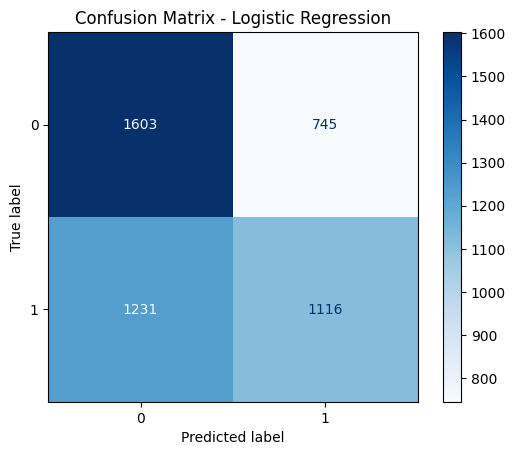

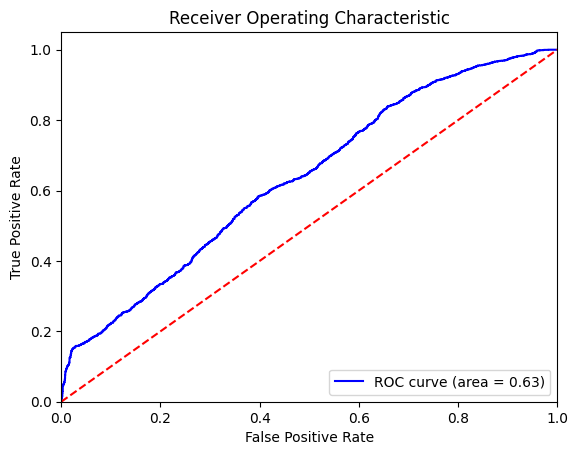

ROC AUC Score: 0.6341913886225411
Model: SVM
F1 Score: 0.664886515353805
Classification Report:
               precision    recall  f1-score   support

           0       0.66      0.51      0.58      2348
           1       0.60      0.74      0.66      2347

    accuracy                           0.63      4695
   macro avg       0.63      0.63      0.62      4695
weighted avg       0.63      0.63      0.62      4695



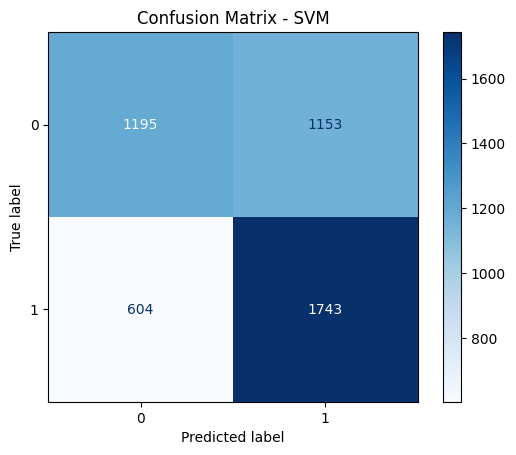

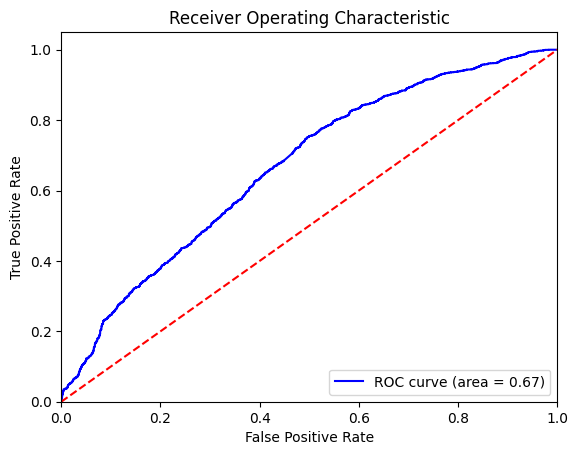

ROC AUC Score: 0.666325182969451
Model: Naive Bayes
F1 Score: 0.3244339303818858
Classification Report:
               precision    recall  f1-score   support

           0       0.54      0.94      0.69      2348
           1       0.78      0.20      0.32      2347

    accuracy                           0.57      4695
   macro avg       0.66      0.57      0.51      4695
weighted avg       0.66      0.57      0.51      4695



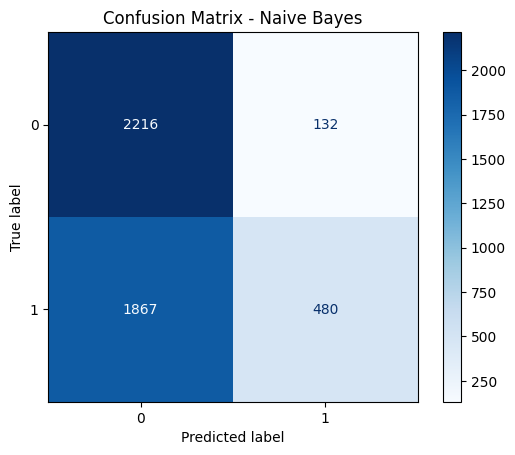

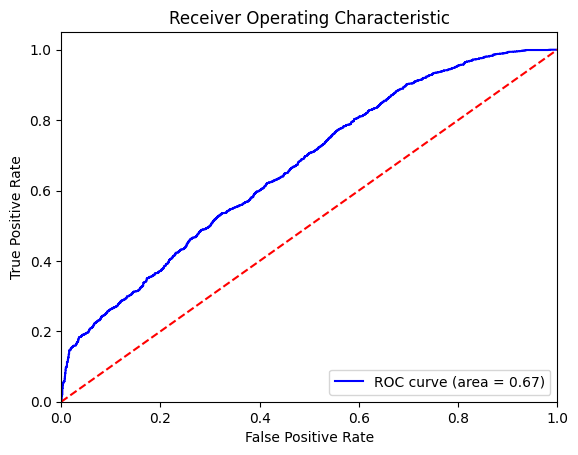

ROC AUC Score: 0.6661441733221358
Model: KNN
F1 Score: 0.7188203972967439
Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.67      0.70      2348
           1       0.69      0.75      0.72      2347

    accuracy                           0.71      4695
   macro avg       0.71      0.71      0.71      4695
weighted avg       0.71      0.71      0.71      4695



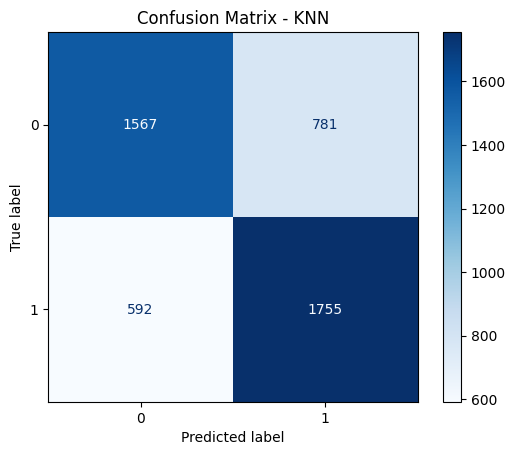

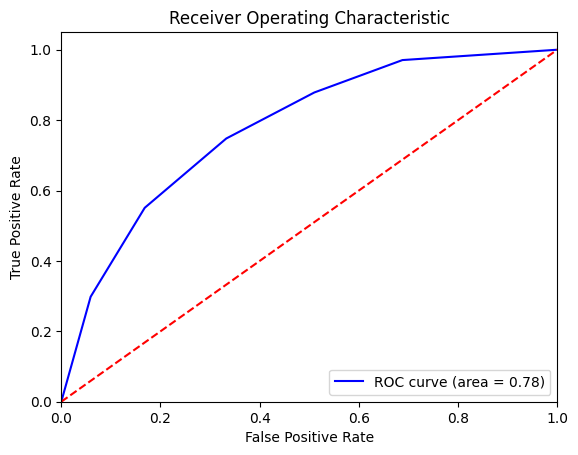

ROC AUC Score: 0.7780810836117585
Model: Decision Tree
F1 Score: 0.9391778523489933
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.92      0.94      2348
           1       0.92      0.95      0.94      2347

    accuracy                           0.94      4695
   macro avg       0.94      0.94      0.94      4695
weighted avg       0.94      0.94      0.94      4695



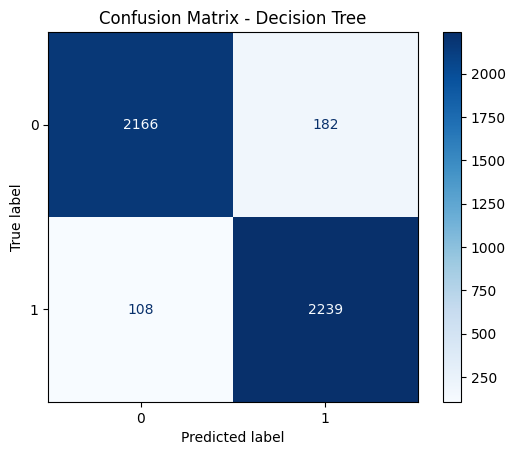

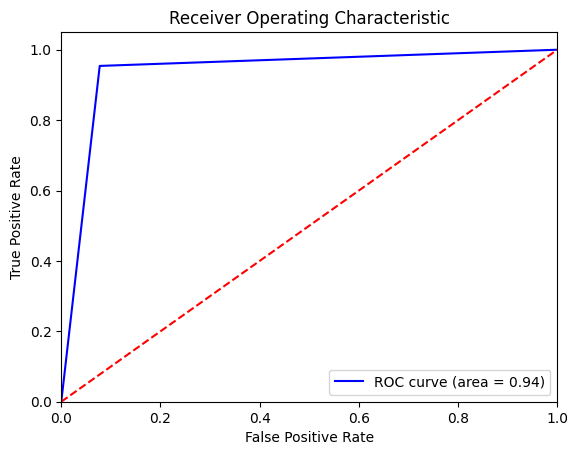

ROC AUC Score: 0.9382355161433386
Model: Random Forest
F1 Score: 0.967154058063149
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.96      0.97      2348
           1       0.96      0.97      0.97      2347

    accuracy                           0.97      4695
   macro avg       0.97      0.97      0.97      4695
weighted avg       0.97      0.97      0.97      4695



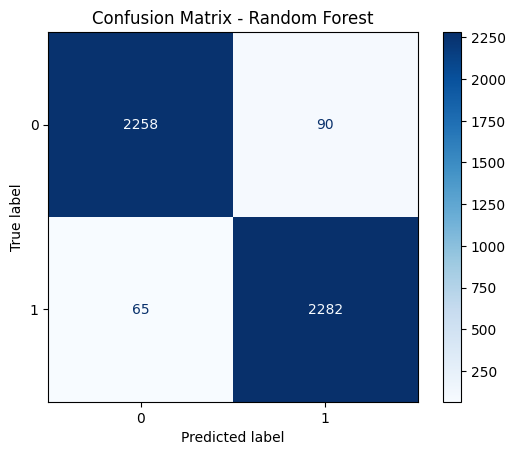

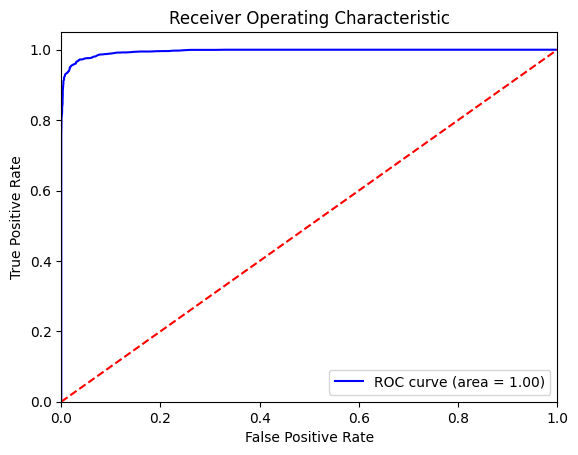

ROC AUC Score: 0.9956752757697855
Model: XGBoost
F1 Score: 0.9648454044896231
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.96      0.96      2348
           1       0.96      0.97      0.96      2347

    accuracy                           0.96      4695
   macro avg       0.96      0.96      0.96      4695
weighted avg       0.96      0.96      0.96      4695



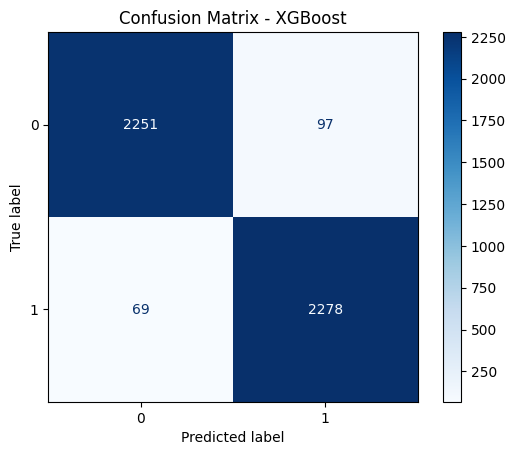

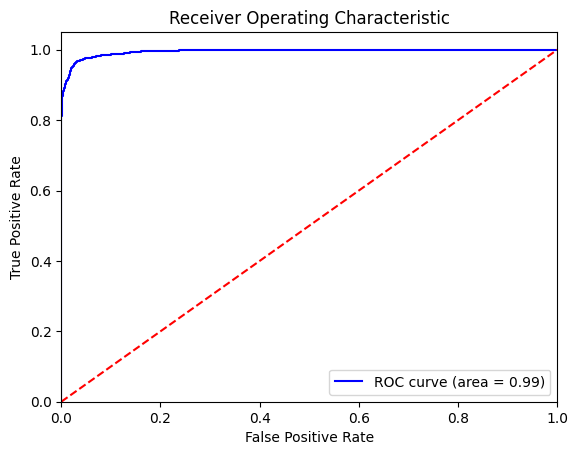

ROC AUC Score: 0.9948228518918275
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 9390, number of negative: 9389
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001684 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 789
[LightGBM] [Info] Number of data points in the train set: 18779, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500027 -> initscore=0.000107
[LightGBM] [Info] Start training from score 0.000107
Model: LightGBM
F1 Score: 0.9566687803846967
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.95      0.96      2348
           1       0.95      0.96      0.96      2347

    accuracy                           0.96      4695
   macro avg       0.96      0.96      0.96      4695
weighted avg       0.96      0.96      0.96      4695



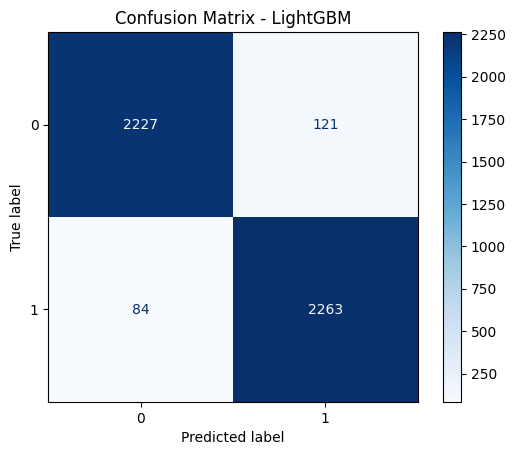

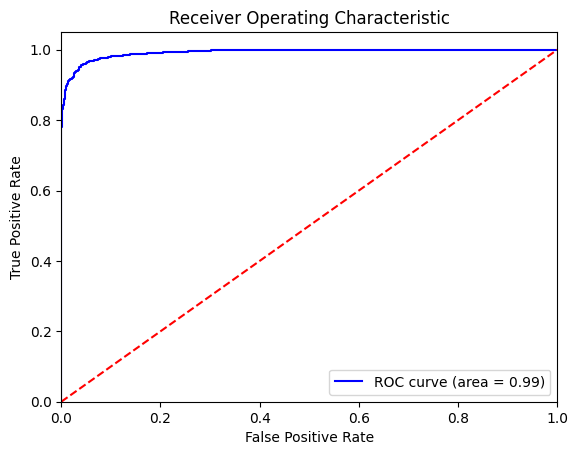

ROC AUC Score: 0.9924378796666011


In [315]:
trained_models = {}
for model_name, model in models.items():
    # # Train the model
    # model = train_model(model, X_train, y_train)
    # # Evaluate the model
    # trained_models[model_name] = evaluate_model(model, X_val, y_val,model_name)
    if model_name in ["Logistic Regression", "SVM", "Naive Bayes", "KNN"]:
        # Train the model
        model = train_model(model, X_train_scaled, y_train)
        # Evaluate the model
        trained_models[model_name] = evaluate_model(model, X_val_scaled, y_val,model_name)
    else:
        # Train the model
        model = train_model(model, X_train, y_train)
        # Evaluate the model
        trained_models[model_name] = evaluate_model(model, X_val, y_val,model_name)
    

**12.2 Cross-Validation Scores**

In [316]:
print("\nCross-Validation Scores (F1):\n")
cv = StratifiedKFold(n_splits=20, shuffle=True, random_state=RANDOM_STATE)
for name, model in models.items():
    scores = cross_val_score(model, X_resampled, y_resampled, scoring='f1', cv=cv)
    print(f"{name}: Mean F1 = {scores.mean():.4f} | Std = {scores.std():.4f}\n")


Cross-Validation Scores (F1):

Logistic Regression: Mean F1 = 0.8829 | Std = 0.0117

SVM: Mean F1 = 0.8243 | Std = 0.0088

Naive Bayes: Mean F1 = 0.7421 | Std = 0.0082

KNN: Mean F1 = 0.9255 | Std = 0.0086

Decision Tree: Mean F1 = 0.9477 | Std = 0.0053

Random Forest: Mean F1 = 0.9690 | Std = 0.0052

XGBoost: Mean F1 = 0.9628 | Std = 0.0044

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 11150, number of negative: 11150
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001673 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 789
[LightGBM] [Info] Number of data points in the train set: 22300, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] Found whitespace in feature_names, replace with und

**12.3 Tune model and find best model params**



--- Tuning Logistic Regression ---
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best Params for Logistic Regression: {'C': 1, 'max_iter': 1000, 'solver': 'lbfgs'}
F1 Score: 0.5304182509505704
Classification Report:
               precision    recall  f1-score   support

           0       0.57      0.68      0.62      2348
           1       0.60      0.48      0.53      2347

    accuracy                           0.58      4695
   macro avg       0.58      0.58      0.57      4695
weighted avg       0.58      0.58      0.57      4695



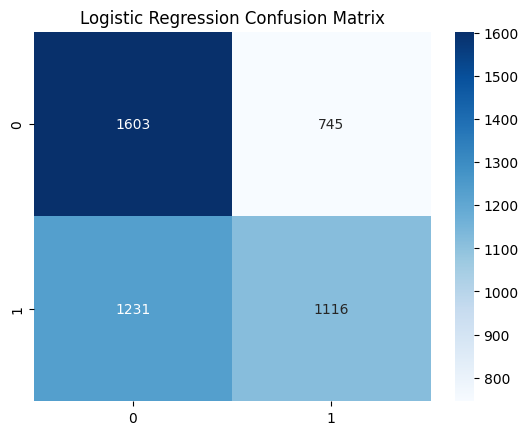

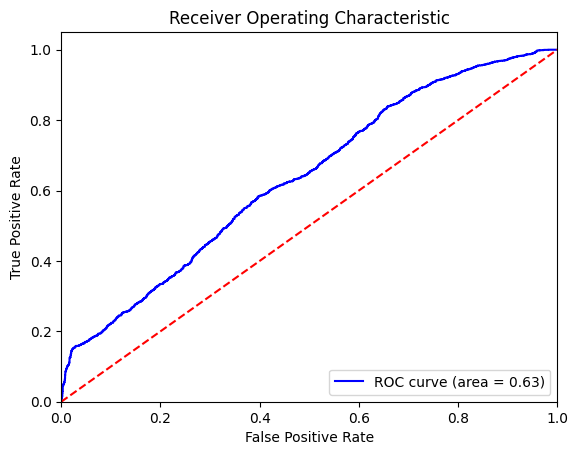

ROC AUC Score: 0.6341913886225411


--- Tuning Naive Bayes ---
Fitting 5 folds for each of 7 candidates, totalling 35 fits
Best Params for Naive Bayes: {'var_smoothing': np.float64(1e-12)}
F1 Score: 0.3244339303818858
Classification Report:
               precision    recall  f1-score   support

           0       0.54      0.94      0.69      2348
           1       0.78      0.20      0.32      2347

    accuracy                           0.57      4695
   macro avg       0.66      0.57      0.51      4695
weighted avg       0.66      0.57      0.51      4695



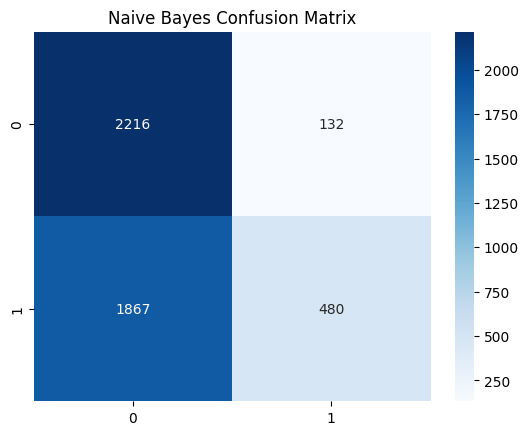

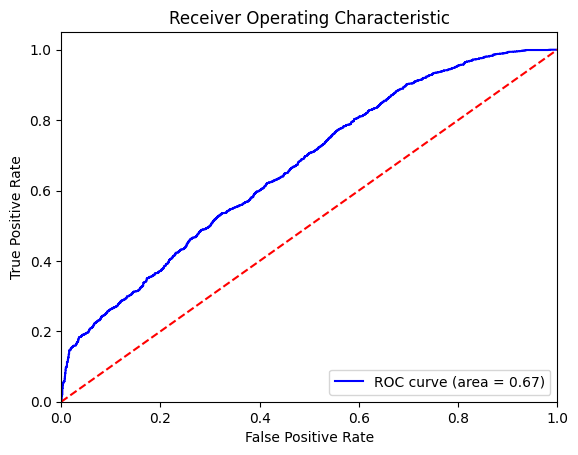

ROC AUC Score: 0.6661441733221358


--- Tuning SVM ---
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best Params for SVM: {'C': 0.1, 'kernel': 'rbf', 'probability': True}
F1 Score: 0.6643770272848692
Classification Report:
               precision    recall  f1-score   support

           0       0.66      0.51      0.58      2348
           1       0.60      0.74      0.66      2347

    accuracy                           0.63      4695
   macro avg       0.63      0.63      0.62      4695
weighted avg       0.63      0.63      0.62      4695



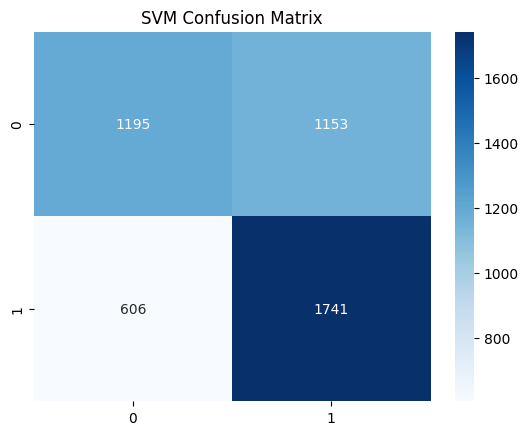

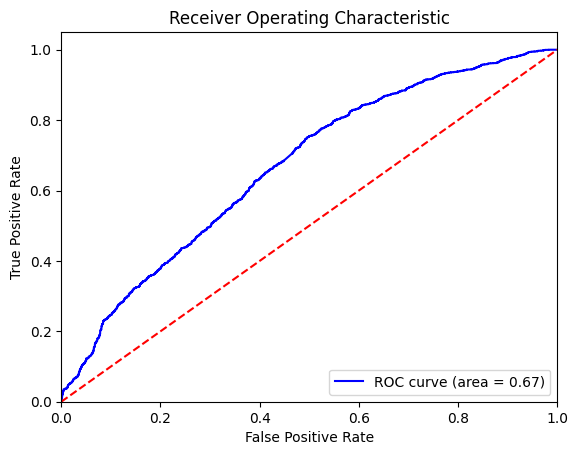

ROC AUC Score: 0.666325182969451


--- Tuning KNN ---
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best Params for KNN: {'n_neighbors': 7, 'weights': 'distance'}
F1 Score: 0.7339983374896093
Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.70      0.72      2348
           1       0.72      0.75      0.73      2347

    accuracy                           0.73      4695
   macro avg       0.73      0.73      0.73      4695
weighted avg       0.73      0.73      0.73      4695



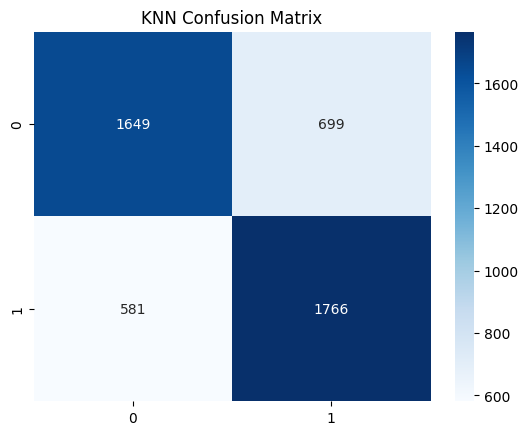

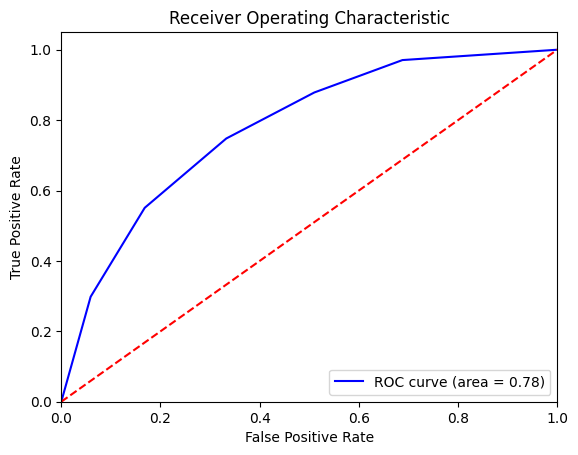

ROC AUC Score: 0.7780810836117585


--- Tuning LightGBM ---
Fitting 5 folds for each of 12 candidates, totalling 60 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 9390, number of negative: 9389
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003599 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 789
[LightGBM] [Info] Number of data points in the train set: 18779, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500027 -> initscore=0.000107
[LightGBM] [Info] Start training from score 0.000107
Best Params for LightGBM: {'learning_rate': 0.1, 'max_depth': -1, 'n_estimators': 200}
F1 Score: 0.967714528462192
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.96      0.97      234

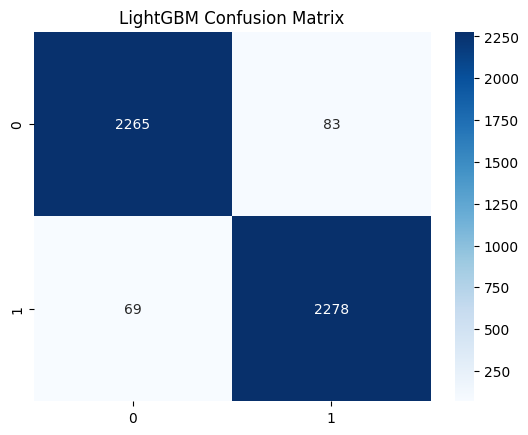

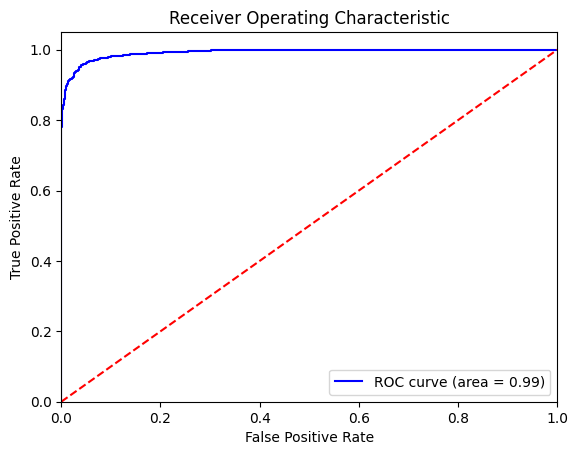

ROC AUC Score: 0.9924378796666011


--- Tuning Decision Tree ---
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best Params for Decision Tree: {'max_depth': 10, 'min_samples_split': 5}
F1 Score: 0.9029803424223208
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.89      0.90      2348
           1       0.90      0.91      0.90      2347

    accuracy                           0.90      4695
   macro avg       0.90      0.90      0.90      4695
weighted avg       0.90      0.90      0.90      4695



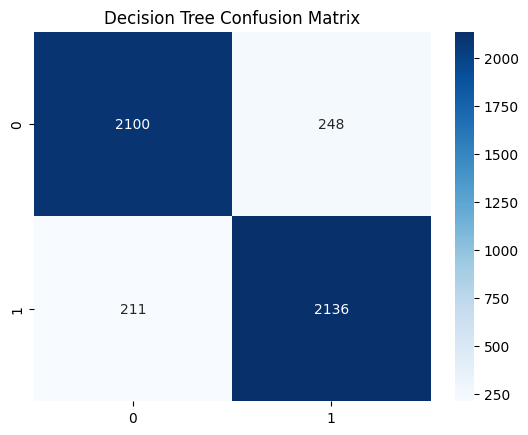

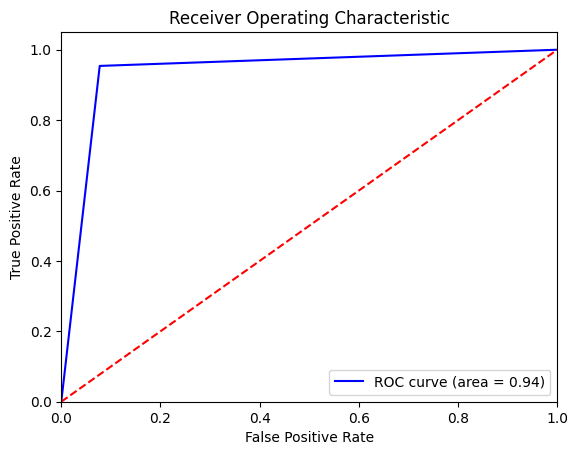

ROC AUC Score: 0.9382355161433386


--- Tuning Random Forest ---
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best Params for Random Forest: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
F1 Score: 0.9667302394575121
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.96      0.97      2348
           1       0.96      0.97      0.97      2347

    accuracy                           0.97      4695
   macro avg       0.97      0.97      0.97      4695
weighted avg       0.97      0.97      0.97      4695



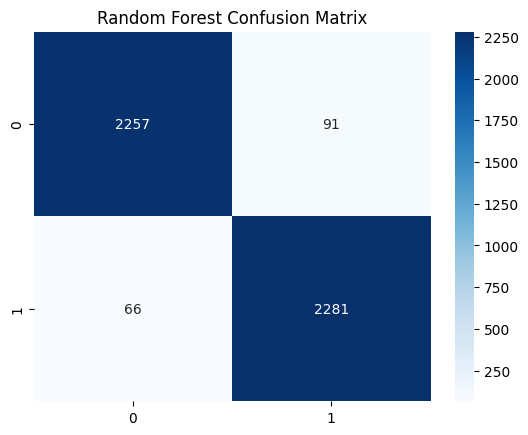

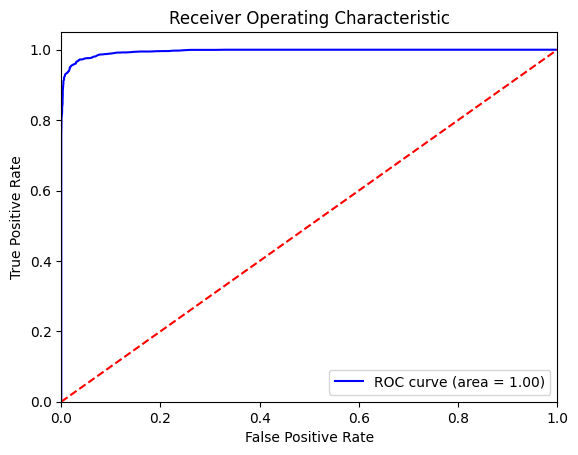

ROC AUC Score: 0.9956752757697855


--- Tuning XGBoost ---
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best Params for XGBoost: {'learning_rate': 0.2, 'max_depth': 10, 'n_estimators': 200, 'subsample': 0.8}
F1 Score: 0.9704641350210971
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.96      0.97      2348
           1       0.96      0.98      0.97      2347

    accuracy                           0.97      4695
   macro avg       0.97      0.97      0.97      4695
weighted avg       0.97      0.97      0.97      4695



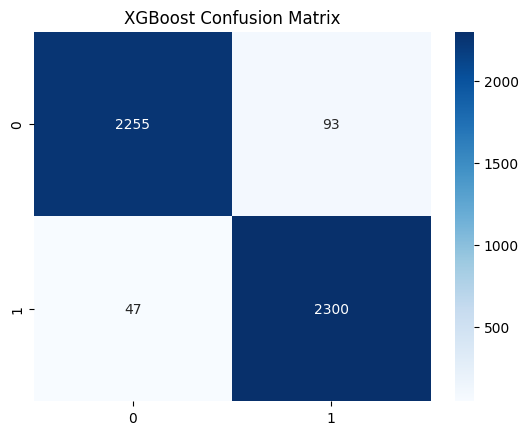

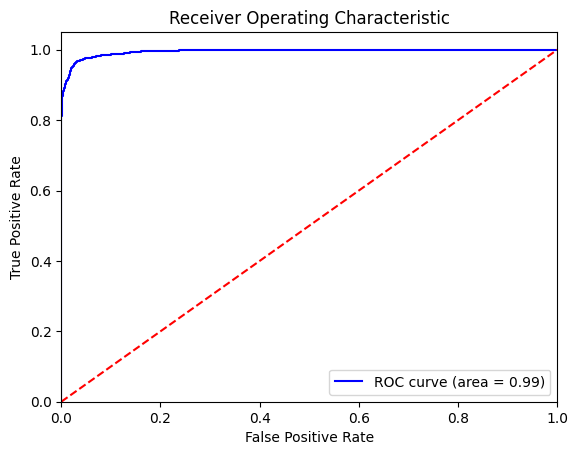

ROC AUC Score: 0.9948228518918275


In [317]:
# Distance-based models (KNN, SVM, Logistic Regression, naive Bayes)
best_logreg = tune_model(models["Logistic Regression"],X_train_scaled,y_train,X_val_scaled,y_val, param_tuning["Logistic Regression"], "Logistic Regression")
best_naive_bayes = tune_model(models["Naive Bayes"],X_train_scaled,y_train,X_val_scaled,y_val, param_tuning["Naive Bayes"], "Naive Bayes")
best_svm = tune_model(models["SVM"] ,X_train_scaled,y_train,X_val_scaled,y_val,param_tuning["SVM"], "SVM")
best_knn = tune_model(models["KNN"] ,X_train_scaled,y_train,X_val_scaled,y_val,param_tuning["KNN"], "KNN")

# Tree-based models (Decision Tree, Random Forest, XGBoost, LightGBM)
best_lgbm = tune_model(models["LightGBM"],X_train,y_train,X_val,y_val, param_tuning["LightGBM"], "LightGBM")
best_dt = tune_model(models["Decision Tree"],X_train,y_train,X_val,y_val, param_tuning["Decision Tree"], "Decision Tree")
best_rf = tune_model(models["Random Forest"],X_train,y_train,X_val,y_val, param_tuning["Random Forest"], "Random Forest")
best_xgb = tune_model(models["XGBoost"],X_train,y_train,X_val,y_val, param_tuning["XGBoost"], "XGBoost")


**12.4 use stacking classsifier on best model parameters**

In [318]:
estimators = [
    # ('lr', best_logreg),
    # ('svm', best_svm),
    # ('nb', best_naive_bayes),
    # ('knn', best_knn),
    ("dt",best_dt),
    ('rf', best_rf),
    ('xgb', best_xgb),
    ('lgbm', best_lgbm)
]

stack_model = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(max_iter=1000),
    cv=5,
    n_jobs=-1,
    passthrough=False
)

Model: stacking
F1 Score: 0.9732711073398388
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.97      0.97      2348
           1       0.97      0.98      0.97      2347

    accuracy                           0.97      4695
   macro avg       0.97      0.97      0.97      4695
weighted avg       0.97      0.97      0.97      4695



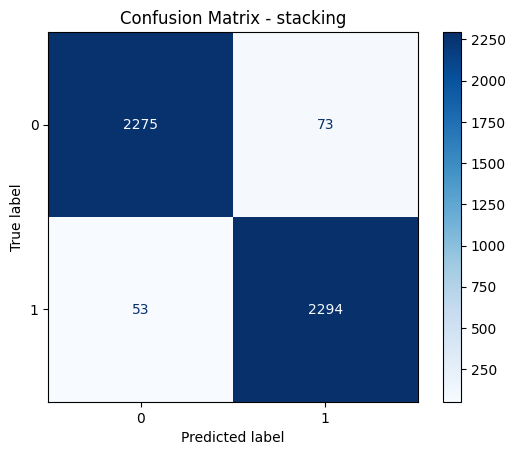

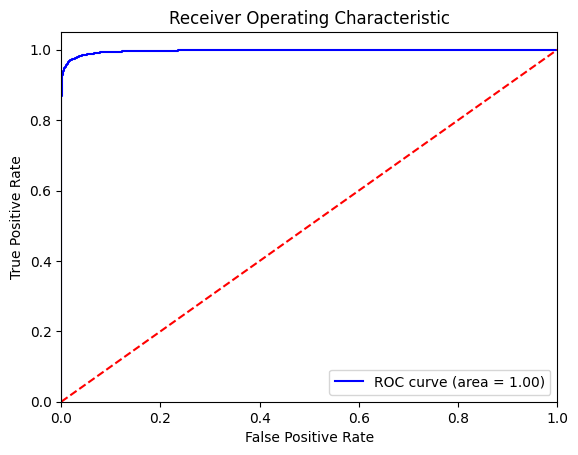

ROC AUC Score: 0.9970873324821494


In [319]:
stack_model = train_model(stack_model, X_train, y_train)
stacked_model_final = evaluate_model(stack_model,X_val,y_val, "stacking")

# 13. Summarize and compare models

**13.1 Defined tuned models**

In [320]:
# define the tuned models
tuned_models = [
    (best_logreg, "logreg_model"),
    (best_naive_bayes, "naive_bayes_model"),
    (best_svm, "svm_model"),
    (best_knn, "knn_model"),
    (best_rf, "rf_model"),
    (best_dt, "decision_tree_model"),
    (best_xgb, "xgb_model"),
    (best_lgbm, "lgbm_model"),
    (stacked_model_final, "stacking_model")
]


**13.2 Evaluate all tuned models on the validation set and collect their scores**

In [321]:
# Evaluate all tuned models on the validation set and collect their scores
model_scores = []
f1_scores =[]
roc_aucs = []
model_names = [name for _, name in tuned_models]
best_models=[]
for model, name in tuned_models:
    if name in ["logreg_model", "svm_model", "naive_bayes_model", "knn_model"]:
        y_pred = model.predict(X_val_scaled)
        y_proba = model.predict_proba(X_val_scaled)[:, 1] if hasattr(model, "predict_proba") else None
    else:
        # For tree-based models, use the original scaled features
        y_pred = model.predict(X_val)
        y_proba = model.predict_proba(X_val)[:, 1] if hasattr(model, "predict_proba") else None
    
    f1 = f1_score(y_val, y_pred)
    roc_auc = roc_auc_score(y_val, y_proba) if y_proba is not None else None
    model_scores.append({
        "Model": name,
        "F1 Score": f1,
        "ROC AUC": roc_auc
    })
    f1_scores.append(f1)
    roc_aucs.append(roc_auc)
    if f1 >= 0.80:
        best_models.append(name)
score_df = pd.DataFrame(model_scores)
score_df = score_df.sort_values(by="F1 Score", ascending=False)
print(score_df)
print(f"\nBest Models with F1 Score >= 0.80: {best_models}")

                 Model  F1 Score   ROC AUC
8       stacking_model  0.973271  0.997087
6            xgb_model  0.970464  0.996633
7           lgbm_model  0.967715  0.995685
4             rf_model  0.966730  0.995685
5  decision_tree_model  0.902980  0.960617
3            knn_model  0.733998  0.812634
2            svm_model  0.664377  0.665334
0         logreg_model  0.530418  0.634191
1    naive_bayes_model  0.324434  0.666144

Best Models with F1 Score >= 0.80: ['rf_model', 'decision_tree_model', 'xgb_model', 'lgbm_model', 'stacking_model']


**13.3 Plot the f1 score annd ROC_AUC for all the models**

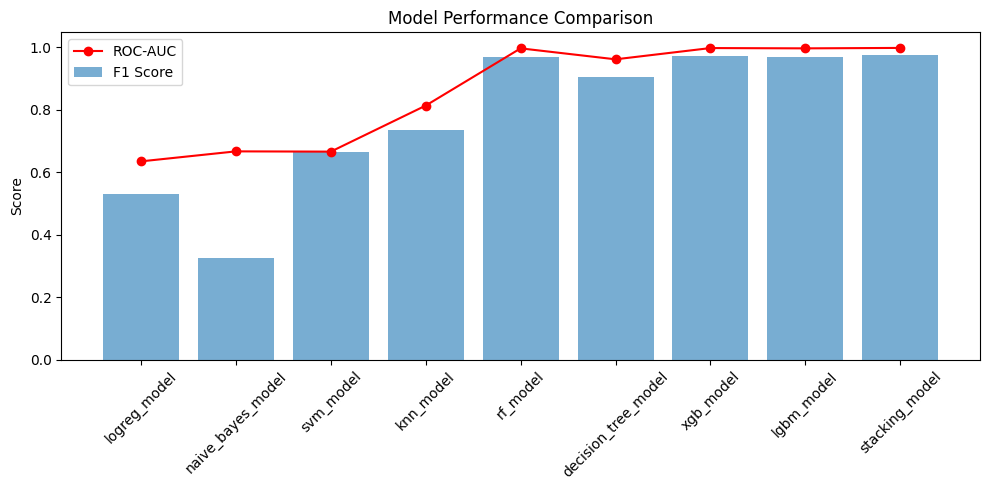

In [322]:
plt.figure(figsize=(10, 5))
plt.bar(model_names, f1_scores, alpha=0.6, label='F1 Score')
plt.plot(model_names, roc_aucs, marker='o', color='red', label='ROC-AUC')
plt.title('Model Performance Comparison')
plt.ylabel('Score')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**13.4 Save the models and final predictions on test data**

In [323]:
for model, name in tuned_models:
    # meta_features = cross_val_predict(model, X_resampled, y_resampled, method='predict_proba', cv=5)
    # if hasattr(model, 'final_estimator_'):
    #     # Use the final estimator of the stacking model for SHAP values
    #     explainer = shap.Explainer(stack_model.final_estimator_, meta_features)
    #     shap_values = explainer(meta_features)
    #     shap.summary_plot(shap_values, meta_features, plot_type='bar')
    if name in best_models:
        save_final_predictions(model, test,features, name,DATA_PREDICTED_PATH)
        save_pickle_file(model, name)
        print(f"Model {name} saved and predictions generated.")

Submission file saved as 'submission_rf_model.csv'
Pickle File saved as rf_model.pkl
Model rf_model saved and predictions generated.
Submission file saved as 'submission_decision_tree_model.csv'
Pickle File saved as decision_tree_model.pkl
Model decision_tree_model saved and predictions generated.
Submission file saved as 'submission_xgb_model.csv'
Pickle File saved as xgb_model.pkl
Model xgb_model saved and predictions generated.
Submission file saved as 'submission_lgbm_model.csv'
Pickle File saved as lgbm_model.pkl
Model lgbm_model saved and predictions generated.
Submission file saved as 'submission_stacking_model.csv'
Pickle File saved as stacking_model.pkl
Model stacking_model saved and predictions generated.


**13.5 Check the prediction on sample data**

In [324]:
sample_rec=test[test["id"]==1].drop("id",axis=1)
sample_rec_dict=sample_rec.to_dict(orient="records")[0]
print(sample_rec_dict)

{'age': 40.0, 'hypertension': 0, 'heart_disease': 0, 'ever_married': 1, 'Residence_type': 1, 'avg_glucose_level': 94.65, 'bmi': 34.7, 'gender_Male': False, 'gender_Other': False, 'work_type_Never_worked': False, 'work_type_Private': True, 'work_type_Self-employed': False, 'work_type_children': False, 'smoking_status_formerly smoked': False, 'smoking_status_never smoked': True, 'smoking_status_smokes': False}


In [325]:
loaded_model=load_pickle_file("stacking_model",MODEL_DIR)
pred=loaded_model.predict(sample_rec[features])[0]
prob=loaded_model.predict_proba(sample_rec[features])[0][1]
print(f"Prediction for sample input : {pred}, Probability: {prob}")

Model stacking_model loaded successfully.
Prediction for sample input : 0, Probability: 0.007279716753783523


## 14. 🏁 Model Comparison Summary & Conclusion

### Model Performance Table

| Model           | F1 Score | ROC AUC  |
|-----------------|----------|----------|
| Stacking        | 0.973    | 0.997    |
| XGBoost         | 0.970    | 0.996    |
| LightGBM        | 0.967    | 0.995    |
| Random Forest   | 0.966    | 0.995    |
| Decision Tree   | 0.902    | 0.960    |


### Summary

- **Stacking Classifier** achieved the highest F1 Score (0.973) and a very high ROC AUC (0.997), indicating excellent overall performance and generalization.
- **XGBoost** closely follows, with nearly identical F1 and slightly higher ROC AUC, showing strong predictive power.
- **Random Forest** and **LightGBM** also performed very well, with F1 Scores above 0.96 and ROC AUCs above 0.99, making them reliable choices.
- **Logistic Regression** lags behind the ensemble models, with a lower F1 Score (0.88) and ROC AUC (0.95), but still provides a reasonable baseline.

### 15 Conclusion

For stroke prediction, **ensemble models** (Stacking, XGBoost, Random Forest, LightGBM,..) significantly outperform Logistic Regression, both in terms of F1 Score and ROC AUC.  
The **Stacking Classifier** offers the best balance of precision and recall, making it the recommended model for deployment.  
Further improvements can be made by exploring advanced feature engineering, deeper hyperparameter tuning, and external validation.

## 16. Assumptions

- The data provided is representative of the real-world population and is free from major sampling biases.
- All features used are relevant and sufficient for predicting stroke risk; no important predictors are missing.
- The SMOTE technique for balancing classes does not introduce unrealistic synthetic samples.
- Feature encoding (LabelEncoder) is appropriate for the categorical variables and does not distort relationships.
- The train/validation split is random and stratified, ensuring fair evaluation.
- No data leakage occurs between training and validation/test sets.


## 17. Future Scope

- **Feature Engineering:** Explore additional features, interaction terms, or domain-specific transformations to improve model performance.
- **Hyperparameter Tuning:** Perform extensive hyperparameter optimization for all models using techniques like Grid Search or Bayesian Optimization.
- **Model Ensembling:** Combine multiple models (e.g., stacking, blending) to leverage their strengths and further boost accuracy.
- **Explainability:** Integrate advanced explainability tools (e.g., SHAP, LIME) for better model interpretation and trust.
- **External Validation:** Test the models on external or real-world datasets to assess generalizability.
- **Deployment:** Develop an end-to-end pipeline for real-time stroke risk prediction in clinical settings.
- **Data Augmentation:** Investigate advanced data augmentation or synthetic data generation methods for rare classes.
- **Temporal Analysis:** If time-series or longitudinal data is available, incorporate temporal patterns for improved prediction.